# Dogs vs. Cats

> Classifier using Keras VGG16 transfer learning with kaggle dogs vs. cats dataset.
>
> https://github.com/evenchange4/nextjs-tfjs-cnn


## Download kaggle dataset

https://stackoverflow.com/a/50650918/1932742

In [0]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

In [6]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# Copy the data set locally.
!rm -rf /content/dataset
!kaggle competitions download --path '/content/dataset' -c dogs-vs-cats

# unzip
!unzip -q '/content/dataset/train.zip' -d '/content/dataset'
!unzip -q '/content/dataset/test1.zip' -d '/content/dataset'

# install tfjs
# !pip install -q tensorflowjs

-rw-r--r-- 1 root root 67 Sep 10 02:33 kaggle.json
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 34.4MB/s]
 96% 260M/271M [00:06<00:00, 44.7MB/s]
100% 271M/271M [00:06<00:00, 46.0MB/s]
 99% 539M/543M [00:08<00:00, 66.7MB/s]
100% 543M/543M [00:09<00:00, 63.2MB/s]


## Mount google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

## Define Constants

In [0]:
DATASET_PATH = "/content/dataset/"
TRAIN_PATH = DATASET_PATH + "/train/"
TEST_PATH = DATASET_PATH + "/test1/"
OUTPUT_PATH = "/content/drive/My Drive/colab/dogs-vs-cats/output/"
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
INPUT_SHAPE=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
batch_size=50
epochs=10


## Import Library

In [9]:
import numpy as np
import pandas as pd 
# import tensorflowjs as tfjs
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Flatten, Dense, BatchNormalization, Dropout
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
import random
import os

print(os.listdir(DATASET_PATH))

['train', 'sampleSubmission.csv', 'test1.zip', 'test1', 'train.zip']


## Prepare data

In [0]:
filenames = os.listdir(TRAIN_PATH)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [7]:
df.head()

,filename,category
0,cat.861.jpg,0
1,cat.7975.jpg,0
2,dog.670.jpg,1
3,dog.9431.jpg,1
4,dog.11146.jpg,1


In [8]:
df.tail()

,filename,category
24995,cat.10509.jpg,0
24996,cat.3889.jpg,0
24997,cat.2865.jpg,0
24998,dog.7537.jpg,1
24999,dog.10830.jpg,1


### See Total In count
From dataset we have 12000 cats and 12000 dogs

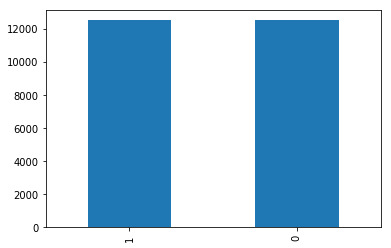

In [9]:
df['category'].value_counts().plot.bar()

### See sample image

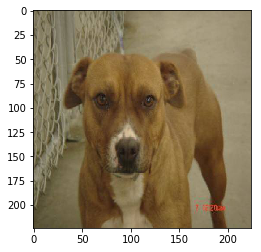

In [10]:
sample = random.choice(filenames)
image = load_img(TRAIN_PATH + sample, target_size=IMAGE_SIZE)
plt.imshow(image)

## Build Model
Use vgg16 pre-trained model as feature extractor

In [10]:
pre_trained_model2 = VGG16(include_top=True, weights='imagenet', input_shape=INPUT_SHAPE)
pre_trained_model2.summary()





553467904/553467096 [==============================] - 35s 0us/step


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____________________________________________________

In [11]:
pre_trained_model = VGG16(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
pre_trained_model.summary()





58892288/58889256 [==============================] - 2s 0us/step


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
________________________________________________________

### Classifier layers

In [12]:
for layer in pre_trained_model.layers:
    layer.trainable = False
    
x = BatchNormalization()(pre_trained_model.output)
x = Flatten()(x)
x = Dense(units=2048, activation="relu")(x)
x = Dense(units=256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(units=2, activation="softmax")(x) # 2 because we have cat and dog classes

model = Model(inputs=pre_trained_model.input, outputs=x)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
________

## Split to training and validation data


In [13]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 
train_df, validate_df = train_test_split(df, test_size=0.20)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
train_df.head()

,filename,category
0,cat.11503.jpg,cat
1,cat.4869.jpg,cat
2,cat.7628.jpg,cat
3,dog.11461.jpg,dog
4,dog.3501.jpg,dog


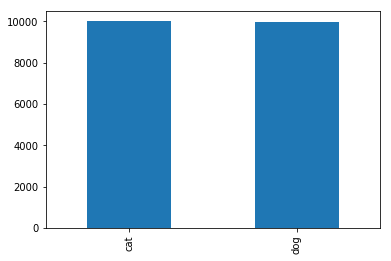

In [14]:
train_df['category'].value_counts().plot.bar()

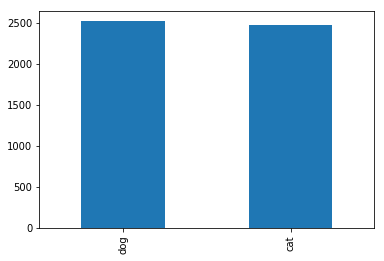

In [15]:
validate_df['category'].value_counts().plot.bar()


In [16]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
print(total_train, total_validate)

20000 5000


## Image Preprocessing
Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches).
https://keras.io/preprocessing/image/
https://chtseng.wordpress.com/2017/11/11/data-augmentation-%E8%B3%87%E6%96%99%E5%A2%9E%E5%BC%B7/

### Traning Generator


In [17]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    directory=TRAIN_PATH,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


### Validation Generator


In [18]:
validation_datagen = ImageDataGenerator(
    rescale=1./255,
)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    directory=TRAIN_PATH,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


### See how our generator work

In [19]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_df

,filename,category
0,cat.8359.jpg,cat


In [20]:
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    directory=TRAIN_PATH,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


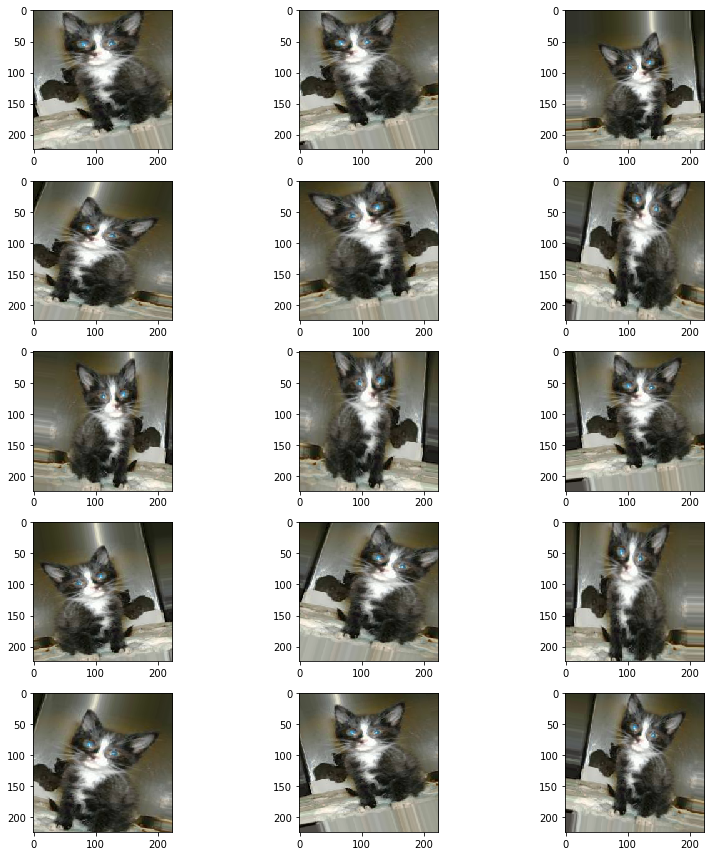

In [21]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Fit Model


### Callbacks
1. Early Stop: To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased
2. Learning Rate Reduction: We will reduce the learning rate when then accuracy not increase for 2 steps

In [0]:
earlystop = EarlyStopping(patience=5)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2,
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [23]:
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks,
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
400/400 [==============================] - 396s 991ms/step - loss: 0.8360 - acc: 0.8528 - val_loss: 0.1887 - val_acc: 0.9272
Epoch 2/10
400/400 [==============================] - 384s 959ms/step - loss: 0.2316 - acc: 0.9055 - val_loss: 0.1789 - val_acc: 0.9318
Epoch 3/10
400/400 [==============================] - 382s 955ms/step - loss: 0.2112 - acc: 0.9143 - val_loss: 0.1717 - val_acc: 0.9368
Epoch 4/10
400/400 [==============================] - 382s 954ms/step - loss: 0.1976 - acc: 0.9220 - val_loss: 0.1691 - val_acc: 0.9376
Epoch 5/10
400/400 [==============================] - 389s 973ms/step - loss: 0.1840 - acc: 0.9256 - val_loss: 0.1716 - val_acc: 0.9356
Epoch 6/10
400/400 [==============================] - 390s 976ms/step - loss: 0.1748 - acc: 0.9326 - val_loss: 0.1621 - val_acc: 0.9416
Epoch 7/10
400/400 [==============================] - 392s 981ms/step - loss: 0.1661 - acc

### Save model

In [0]:
!mkdir -p '/content/drive/My Drive/colab/dogs-vs-cats/output'
model.save(OUTPUT_PATH + 'model.h5')

### Virtualize Training

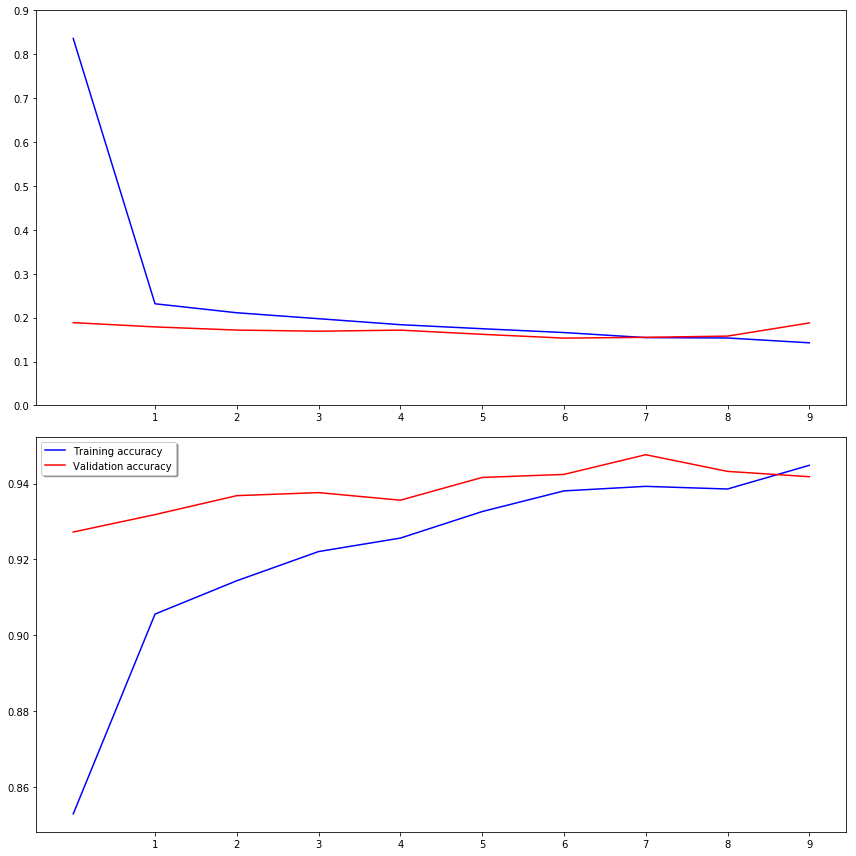

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Prepare Testing Data


In [26]:
test_filenames = os.listdir(TEST_PATH)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
nb_samples

12500

### Create Testing Generator


In [27]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    TEST_PATH, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


## Predict

In [28]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
predict

array([[1.6000536e-08, 1.0000000e+00],
       [1.7234206e-16, 1.0000000e+00],
       [1.8517955e-26, 1.0000000e+00],
       ...,
       [9.9961084e-01, 3.8916341e-04],
       [9.9999964e-01, 3.3506586e-07],
       [1.0520633e-10, 1.0000000e+00]], dtype=float32)

In [29]:
test_df['category'] = np.argmax(predict, axis=-1)
test_df.head()

,filename,category
0,10569.jpg,1
1,10261.jpg,1
2,11050.jpg,1
3,11841.jpg,1
4,9588.jpg,0


In [30]:
print(train_generator.class_indices.items())
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
label_map

dict_items([('cat', 0), ('dog', 1)])


{0: 'cat', 1: 'dog'}

In [31]:
test_df['category'] = test_df['category'].replace(label_map)
test_df.head()

,filename,category
0,10569.jpg,dog
1,10261.jpg,dog
2,11050.jpg,dog
3,11841.jpg,dog
4,9588.jpg,cat


### Virtaulize Result

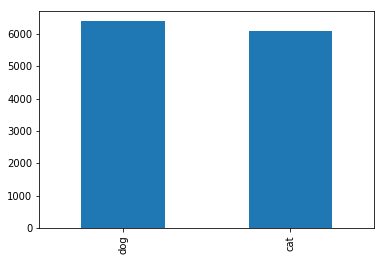

In [32]:
test_df['category'].value_counts().plot.bar()


### See predicted result with images

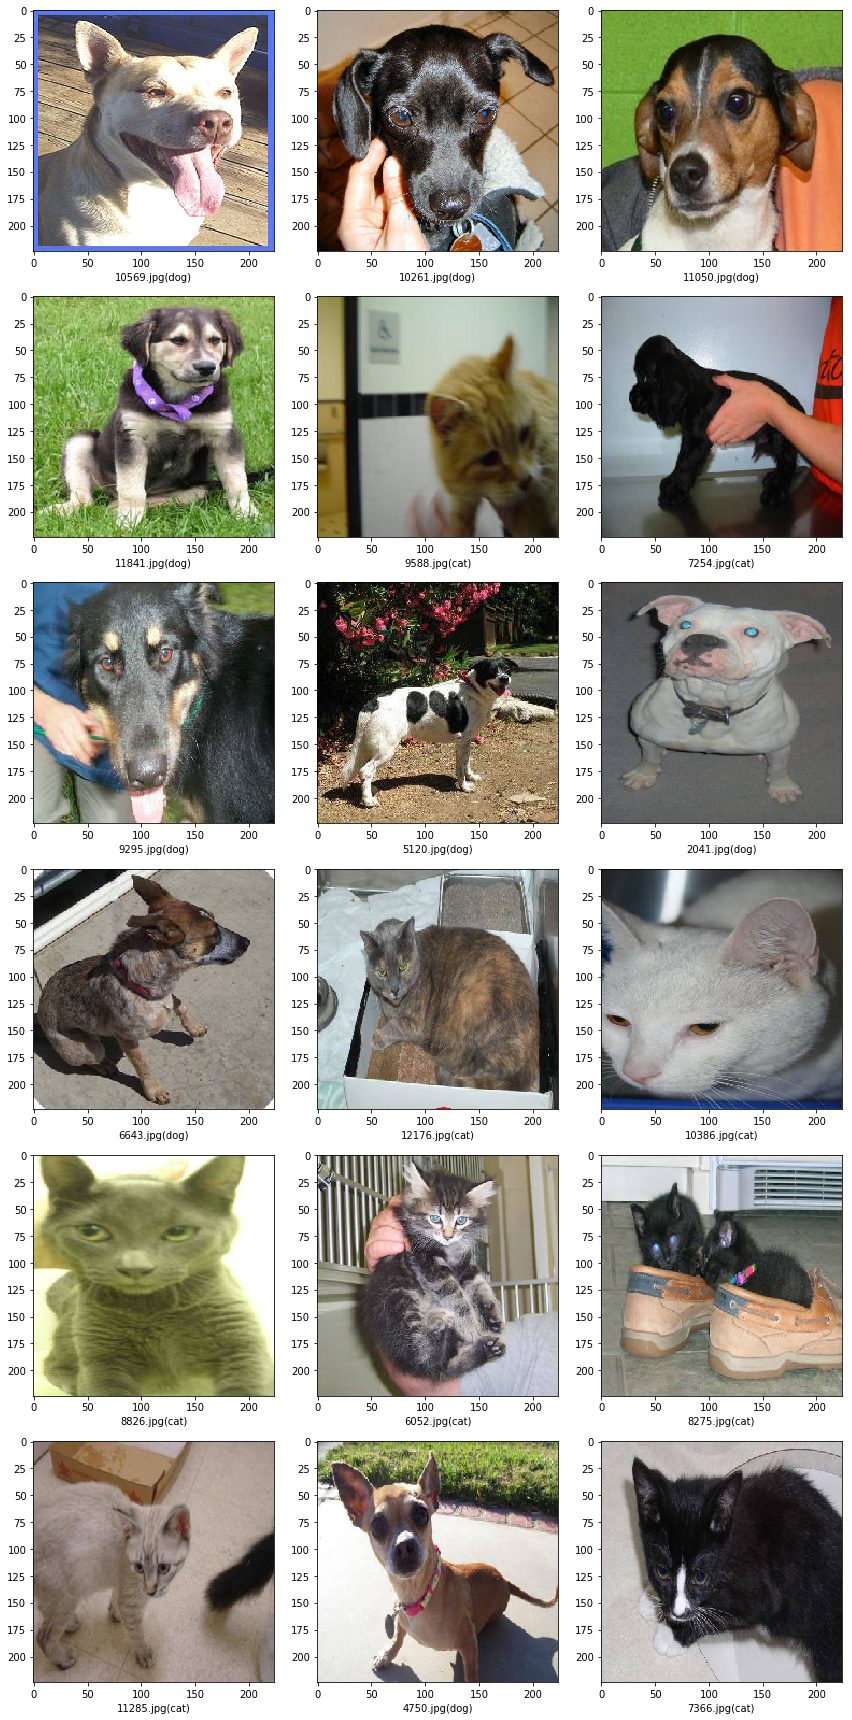

In [33]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(TEST_PATH+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

## Submission

In [0]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv(OUTPUT_PATH + 'submission.csv', index=False)

In [35]:
sample1 = test_df.sample(1)
sample1['filename'] = TEST_PATH + sample1['filename']
print(sample1)
sample_filename = sample1['filename'].item()
print(sample_filename)

                              filename  category
9028  /content/dataset//test1/4603.jpg         1
/content/dataset//test1/4603.jpg


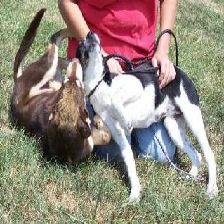

In [36]:
from keras.preprocessing.image import load_img
sample_img = load_img(sample_filename, target_size=IMAGE_SIZE)
sample_img

In [37]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
x1 = image.img_to_array(sample_img)
print(x1)
x1 = np.expand_dims(x1, axis=0)
print(x1)
x1 = preprocess_input(x1)
print(x1)

[[[110. 128.  90.]
  [149. 167. 129.]
  [109. 127.  89.]
  ...
  [147. 162. 129.]
  [145. 162. 128.]
  [138. 145. 112.]]

 [[ 98. 116.  78.]
  [139. 157. 119.]
  [142. 158. 121.]
  ...
  [137. 152. 119.]
  [140. 157. 123.]
  [145. 152. 119.]]

 [[143. 159. 122.]
  [121. 137. 100.]
  [143. 159. 122.]
  ...
  [131. 145. 112.]
  [137. 152. 119.]
  [156. 161. 129.]]

 ...

 [[127. 135. 111.]
  [148. 153. 130.]
  [171. 175. 152.]
  ...
  [120. 125.  95.]
  [114. 119.  89.]
  [111. 115.  90.]]

 [[149. 157. 133.]
  [143. 148. 125.]
  [186. 190. 165.]
  ...
  [123. 126.  97.]
  [118. 123.  93.]
  [117. 121.  96.]]

 [[137. 145. 121.]
  [152. 158. 132.]
  [164. 168. 143.]
  ...
  [122. 122.  94.]
  [119. 122.  93.]
  [131. 135. 110.]]]
[[[[110. 128.  90.]
   [149. 167. 129.]
   [109. 127.  89.]
   ...
   [147. 162. 129.]
   [145. 162. 128.]
   [138. 145. 112.]]

  [[ 98. 116.  78.]
   [139. 157. 119.]
   [142. 158. 121.]
   ...
   [137. 152. 119.]
   [140. 157. 123.]
   [145. 152. 119.]]

  [[

In [38]:
sample_pre = model.predict(x1)
print(sample_pre)
print(sample_pre.argmax(axis=-1))
label_map

[[0. 1.]]
[1]


{0: 'cat', 1: 'dog'}